**The goal is to find the intrinsic and extrinsic parameters on
camera on Xiaomi Mi A1 mobile phone. before getting started I disabled autofocus mode of the camera.
I made 31 photos of chessboard.**

**The size of square on the chessboard I used is 15 mm. The key is that we will know each square size and we will assume each square is equal. It means, that now we know the coordinates of each point on the chess plane. After that we can use the formulas to define intrinsic and extrinsic parameters**

In [1]:
import numpy as np
import cv2
import glob
from skimage.morphology import closing, square
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20,15)

### Calibration code

The chessboard is a 9x6 matrix so we set our width=9 and height=6. These numbers are the intersection points square corners met. “Criteria” is our computation criteria to iterate calibration function. 

objpoints is the map we use for the chessboard. imgpoints is a matrix that holds chessboard corners in the 3D world. These coordinates are coming from the pictures we have taken.

We have a for loop to iterate over the images. cv2.imread gets the image and cv2.cvtColor changes it to grayscale. cv2.findChessboardCorners gets the points and we already have the points.

If the function returns successfully we can start to interpolate. 
The last step, use calibrateCamera function and read the parameters then we save the camera matrix to a yml file.

In [2]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

def calibrate(dirpath, prefix, image_format, square_size, width=9, height=6):
    """ Apply camera calibration operation for images in the given directory path. """
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,6,0)
    objp = np.zeros((height*width, 3), np.float32)
    objp[:, :2] = np.mgrid[0:width, 0:height].T.reshape(-1, 2)

    objp = objp * square_size

    # Arrays to store object points and image points from all the images.
    objpoints = []  # 3d point in real world space
    imgpoints = []  # 2d points in image plane.

    if dirpath[-1:] == '/':
        dirpath = dirpath[:-1]

    images = glob.glob('**/*.jpg')
    print (images)
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chess board corners
        ret, corners = cv2.findChessboardCorners(gray, (width, height), None)

        # If found, add object points, image points (after refining them)
        if ret:
            objpoints.append(objp)

            corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
            imgpoints.append(corners2)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (width, height), corners2, ret)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

    return [ret, mtx, dist, rvecs, tvecs]

**Here save_cofficients and load_coefficients are implemented.**

**These methods are responsible of writing and reading the camera matrix and the distortion coefficients**

In [10]:
def save_coefficients(mtx, dist, path):
    """ Save the camera matrix and the distortion coefficients to given path/file. """
    cv_file = cv2.FileStorage(path, cv2.FILE_STORAGE_WRITE)
    cv_file.write("K", mtx)
    cv_file.write("D", dist)
    # note you *release* you don't close() a FileStorage object
    cv_file.release()
def load_coefficients(path):
    """ Loads camera matrix and distortion coefficients. """
    # FILE_STORAGE_READ
    cv_file = cv2.FileStorage(path, cv2.FILE_STORAGE_READ)

    # note we also have to specify the type to retrieve other wise we only get a
    # FileNode object back instead of a matrix
    camera_matrix = cv_file.getNode("K").mat()
    dist_matrix = cv_file.getNode("D").mat()

    cv_file.release()
    return [camera_matrix, dist_matrix]

**Run Camera Calibration:**

In [20]:

def run_camera_calibration():

    image_dir = "/dataset" #image directory path
    image_format = "jpg" #image format, png/jpg
    prefix = ""
    square_size = 0.015 #1.5cm
    width = 6 #chessboard height size, default is 6
    height = 9 #chessboard width size, default is 9
    
    save_file = "calib_mat.yml" #YML file to save calibration matrices
    ret, mtx, dist, rvecs, tvecs = calibrate(image_dir, prefix, image_format, square_size, width, height)
    save_coefficients(mtx, dist, save_file)
    print("Calibration is finished. RMS: ", ret)
    save_coefficients(mtx, dist, save_file)
    print("Calibration is finished. RMS: ", ret)
run_camera_calibration()

Calibration is finished. RMS:  3.183059807249499


## Estimating the height and width of the Rubik's Cube


***Now since we have calibrated our camera, and stored intrinsic and extrinsic parameters. I took a photo of a rubik's cube using the calibrated camera, and we want to estimate the height and width of the selected
object using both a ruler and an image from the calibrated camera. ***

In [69]:
img = cv2.imread('IMG_20201001_133037.jpg')

#chessboard parameters
square_size = 0.015 #1.5cm
width = 6 #chessboard height size, default is 6
height = 9 #chessboard width size, default is 9

save_file = "calib_mat.yml" #YML file to save calibration matrices
objp = np.zeros((height*width, 3), np.float32)
objp[:, :2] = np.mgrid[0:width, 0:height].T.reshape(-1, 2)

objp = objp * square_size

# Arrays to store object points and image points from all the images.
objpoints = []  # 3d point in real world space
imgpoints = []  # 2d points in image plane.




gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Find the chess board corners
ret, chessboard_corners = cv2.findChessboardCorners(gray, (width, height), None)

# If found, add object points, image points (after refining them)
if ret:
    objpoints.append(objp)

    corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
    imgpoints.append(corners2)



**Now we need to find the corners coordinates of rubik's cube**


**To do that we need to either do some image processing or to hardcoded corners into an array by cheating the points from the image. Well I chose the long way for the sake of having some fun :P**

**I tried to use different color spaces (RGB, HSV, YUV, and LAB) and I found LAB is a good choice in our case**

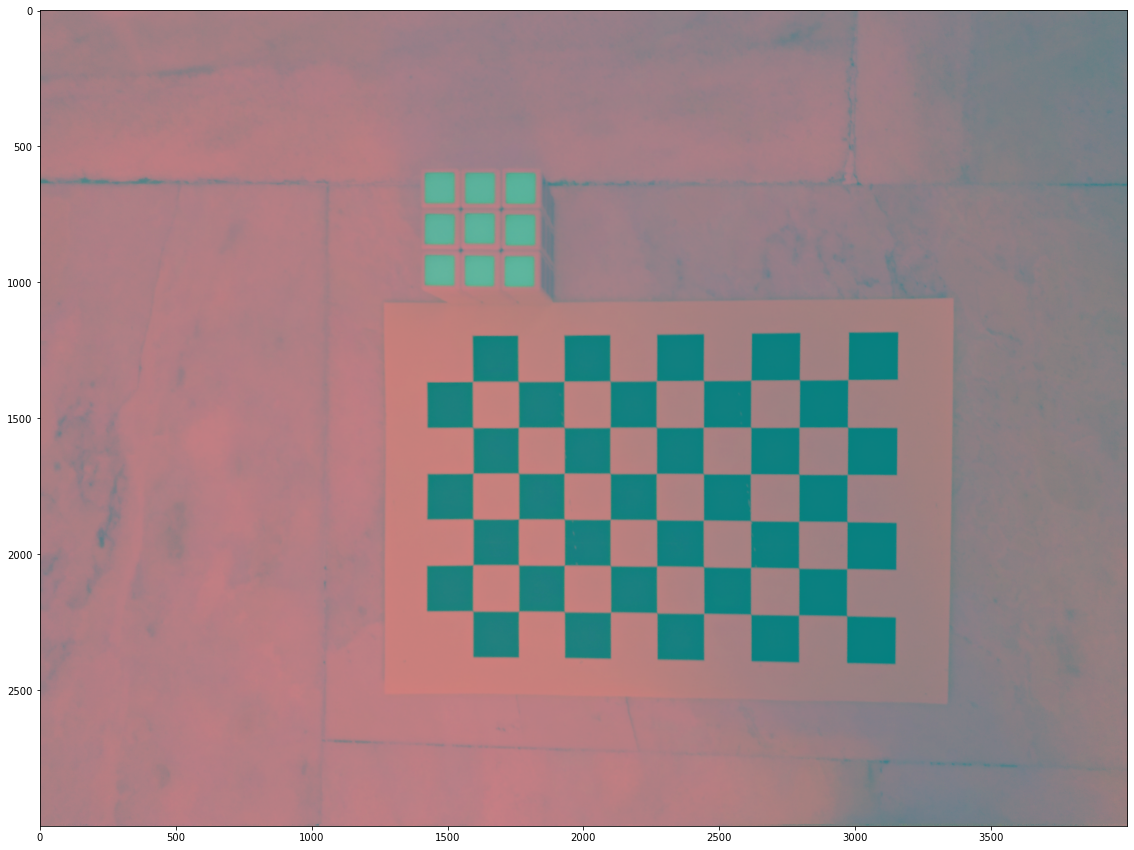

In [11]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2LAB))
plt.show()

## Undistort the Image

***Use the cameraParameters object to remove lens distortion from the image. This is necessary for accurate measurement.***

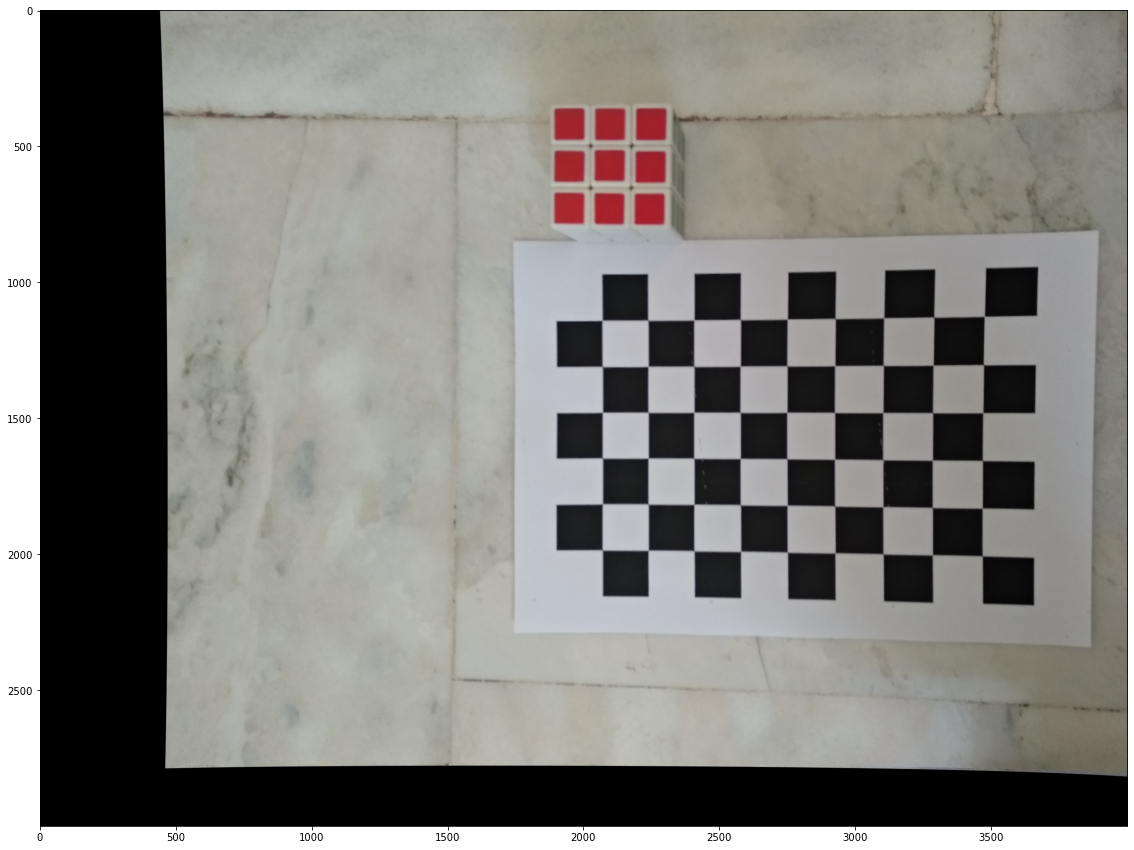

In [95]:
h, w = img.shape[:2]
mtx, dist = load_coefficients("calib_mat.yml")
newCameraMtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), 1, (w, h))
map1, map2 = cv2.initUndistortRectifyMap(mtx, dist, None, None, (w, h), cv2.CV_32FC1)
undistortedImg = cv2.remap(img, map1, map2, cv2.INTER_LINEAR)

plt.imshow(cv2.cvtColor(undistortedImg, cv2.COLOR_BGR2RGB))
plt.show()

**Just to make the problem easier temporarily we will eliminate the padding area**

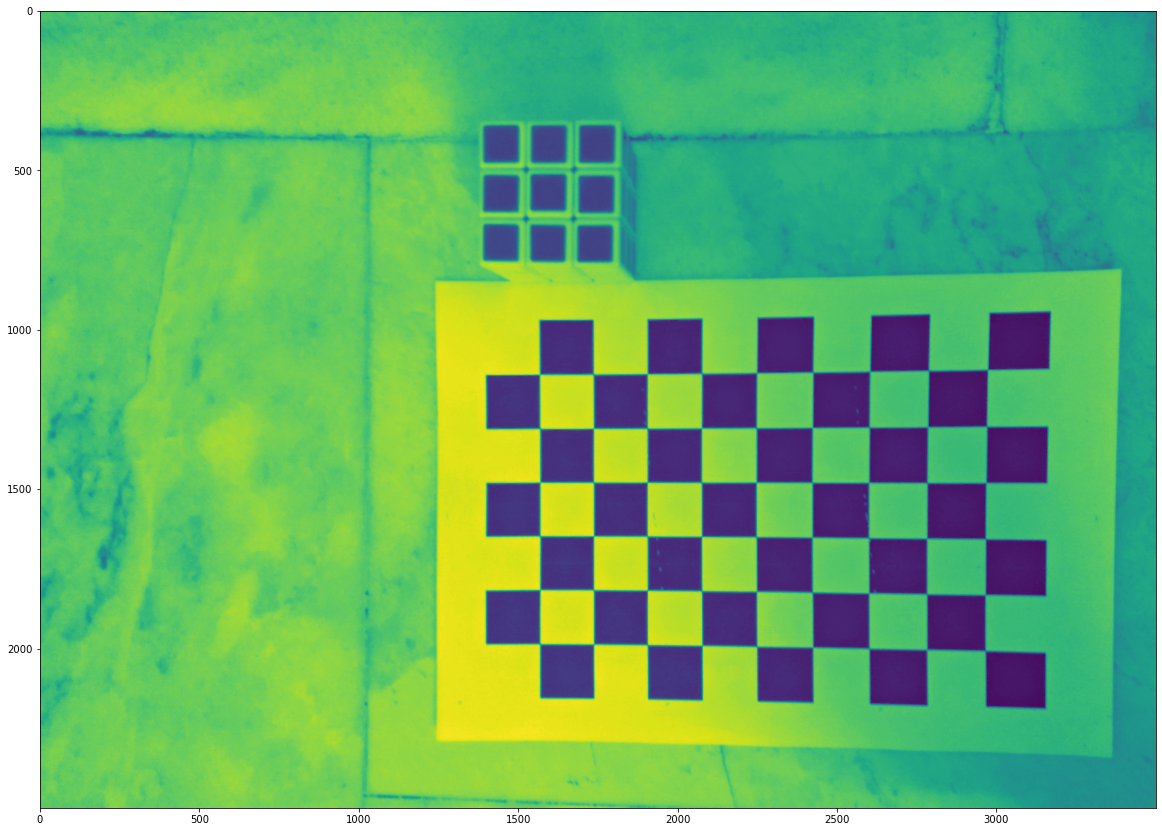

In [13]:
plt.imshow(undistortedImg[:-500,500:,0])
plt.show()

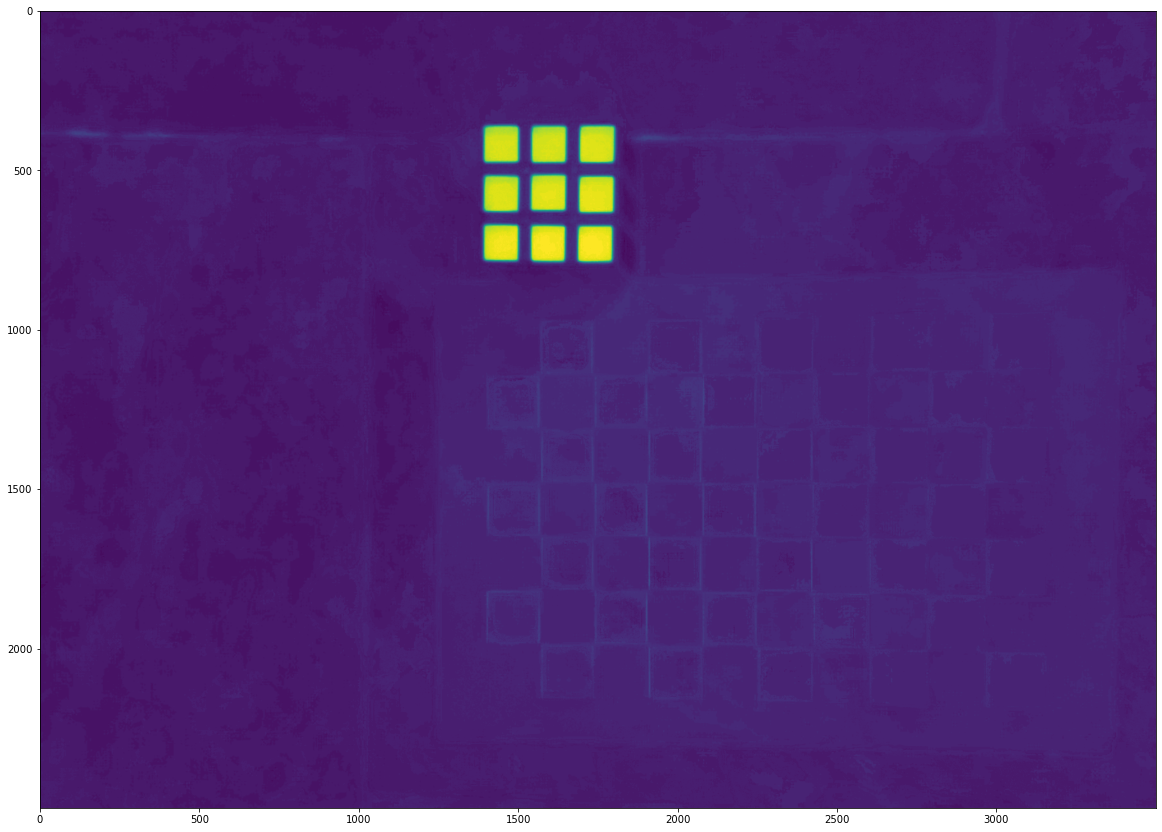

In [33]:
undistortedImg_tmp = undistortedImg[:-500,500:,:]
lab_img = cv2.cvtColor(undistortedImg_tmp, cv2.COLOR_BGR2LAB)
plt.imshow(lab_img[:,:,1])
plt.show()

**To find the contour of the object we will use the closing morphological transform**

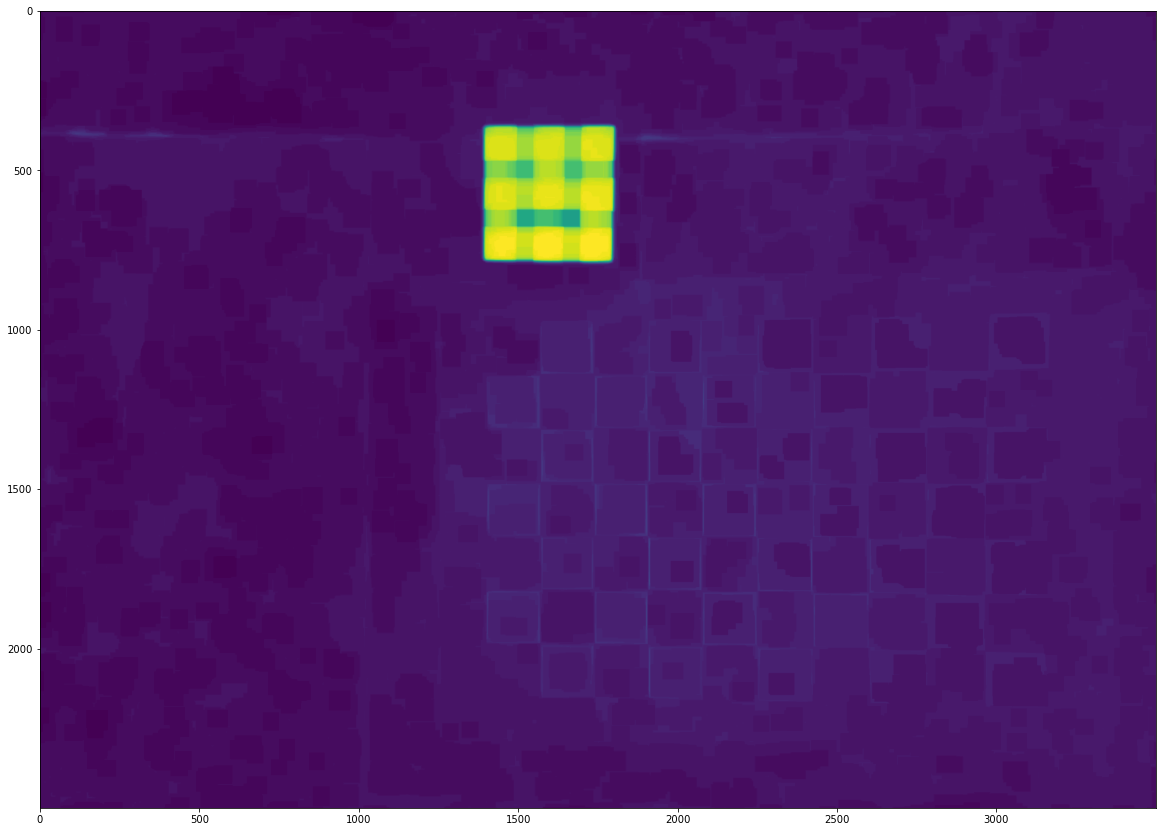

In [34]:
cube_img = lab_img[:,:,1]
tst = closing(cube_img, square(50))
plt.imshow(tst)
plt.show()

**Duh! why we still have a gray scale image let's convert it to binary image to make our calculations faster and even having better results**

In [35]:
tst[tst<150]=0
tst[tst>=150]=1

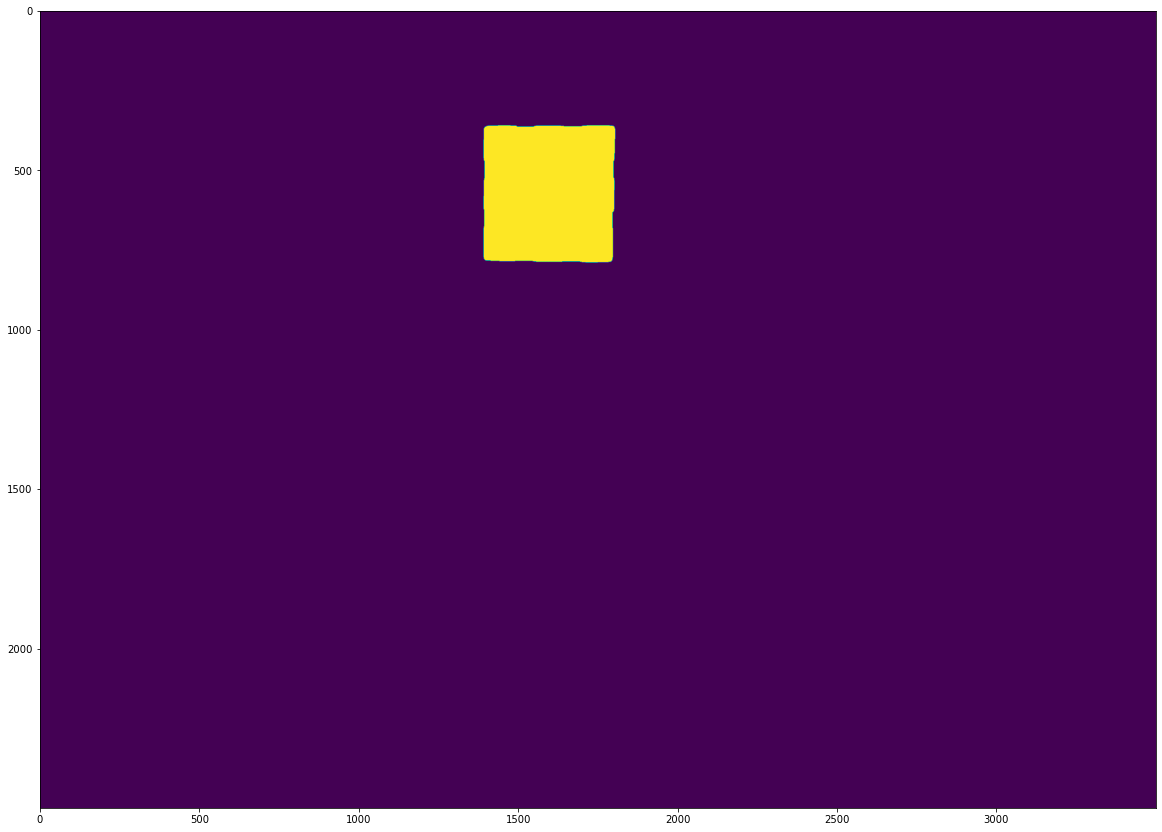

In [36]:
plt.imshow(tst)
plt.show()

**Let's use cv2.goodFeaturesToTrack to get corners of the object and we need to calculate the new chessboard corners**

In [56]:
corners = cv2.goodFeaturesToTrack(tst, 4, 0.45, 50)

In [97]:
gray = cv2.cvtColor(undistortedImg, cv2.COLOR_BGR2GRAY)

# Find the chess board corners
ret, chessboard_corners = cv2.findChessboardCorners(gray, (width, height), None)

**Let's visualize the corners to check the quality of result**

In [99]:
for i in range(4):
    x, y = corners[i, 0, :]
    x+=500
    x = int(x)
    undistortedImg = cv2.circle(undistortedImg, (x,y), radius=10, color=(255, 0, 255), thickness=10)


<ipython-input-99-d4dd55457de8>:5: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  undistortedImg = cv2.circle(undistortedImg, (x,y), radius=10, color=(255, 0, 255), thickness=10)


In [100]:
undistortedImg = cv2.drawChessboardCorners(undistortedImg, (width, height), chessboard_corners, ret)

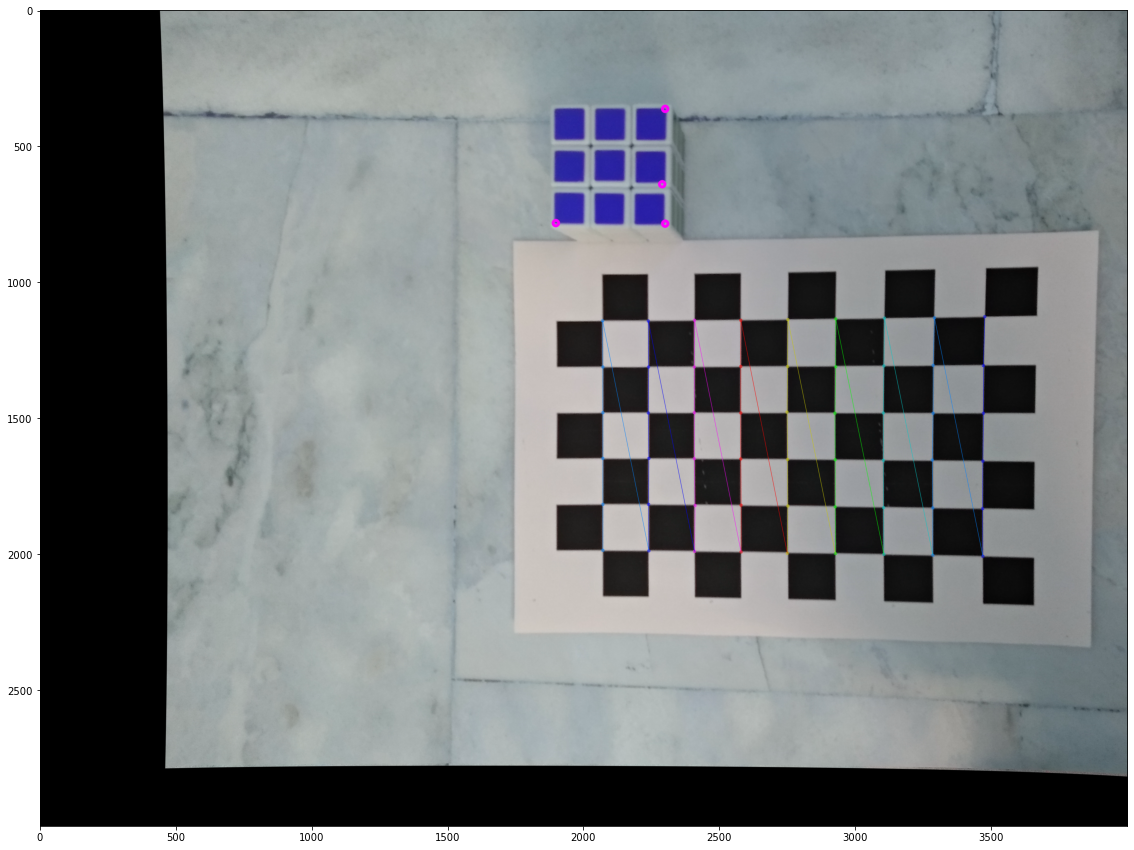

In [101]:
plt.imshow(undistortedImg)

**Well that's not bad, I think it's enough for now since we have the ability to calculate the sides of the rubik's cube and block size of chessboard**

**To calculate the block size of chessboard we could sort the corners by euclidean distance and calculate the difference between them over the unmatched axis**

**For the cube we will calculate two sides of it (they should be almost equal to each other)**

In [127]:
def get_ordered_list(points):
    points.sort(key = lambda p: np.sqrt((p[0])**2 + (p[1])**2))
    return points

In [128]:
sorted_chessboard_corners = []
for i in range(len(chessboard_corners)):
    sorted_chessboard_corners.append(list(chessboard_corners[i,0]))

In [129]:
sorted_chessboard_corners = get_ordered_list(sorted_chessboard_corners)

In [135]:
sorted_chessboard_corners

[[2067.5, 1141.5],
 [2069.0, 1312.0],
 [2235.5, 1143.0],
 [2069.0, 1480.0],
 [2237.0, 1312.0],
 [2069.0, 1648.5],
 [2405.5, 1140.5],
 [2236.5, 1481.0],
 [2405.0, 1312.0],
 [2069.0, 1817.0],
 [2237.5, 1648.5],
 [2576.0, 1139.5],
 [2405.0, 1480.0],
 [2069.0, 1985.5],
 [2237.0, 1817.0],
 [2575.5, 1310.0],
 [2405.0, 1649.0],
 [2575.5, 1481.0],
 [2749.0, 1137.5],
 [2237.5, 1987.5],
 [2407.5342, 1820.942],
 [2748.0, 1310.0],
 [2575.5, 1650.0],
 [2745.9934, 1477.5974],
 [2405.5, 1989.5],
 [2925.0, 1135.0],
 [2577.0, 1820.0],
 [2925.2395, 1310.8247],
 [2747.5, 1651.5],
 [2577.0, 1991.5],
 [2922.0, 1481.5],
 [2749.0, 1823.0],
 [3103.5, 1132.5],
 [2923.0, 1653.0],
 [3101.5, 1308.5],
 [2747.4314, 1996.9741],
 [3099.5, 1481.0],
 [2923.0, 1825.5],
 [3288.0, 1131.0],
 [3100.5, 1655.0],
 [3283.0103, 1306.0217],
 [2924.0, 1997.5],
 [3101.2585, 1829.2068],
 [3283.0, 1482.0],
 [3472.5845, 1126.9135],
 [3279.612, 1654.3538],
 [3102.0, 2001.0],
 [3467.8948, 1307.2922],
 [3282.0, 1830.5],
 [3467.5, 1482.0]

In [138]:
block_size_width = sorted_chessboard_corners[3][1] - sorted_chessboard_corners[1][1]
block_size_width

168.0

In [118]:
corners

array([[[1787.9863 ,  640.5505 ]],

       [[1798.2576 ,  785.61615]],

       [[1396.     ,  783.     ]],

       [[1798.     ,  363.     ]]], dtype=float32)

In [132]:
rubik_width = corners[1,0,1] - corners[3,0,1]
rubik_width

422.61615

In [139]:
rubik_height = corners[1,0,0] - corners[2,0,0]
rubik_height

402.25757

In [140]:
rubik_width_mm = rubik_width/block_size_width*150
rubik_width_mm

377.3358464241028

In [141]:
rubik_height_mm = rubik_height/block_size_width*150
rubik_height_mm

359.15855169296265

**Rubik's cube dimensions using ruler are 5.5 cm for each side 
and the result we got is 3.77 cm by 3.59 cm**